In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from sklearn.metrics import mean_squared_error
from math import sqrt

from IPython.display import clear_output
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
# from torchvision import transforms

from sklearn.metrics import mean_squared_error as MSE_sklearn
MSE_torch = torch.nn.MSELoss()

In [2]:
df = pd.read_csv('all_data_Moscow_mean_TPQW.csv')
df.head()

,Unnamed: 0,date,T,P,Q,W
0,0,20151201,272.237556,97735.347656,0.003635,4.183001
1,1,20151202,270.353706,98692.496094,0.003340,1.710113
2,2,20151203,270.480820,100191.763672,0.003074,1.405735
3,3,20151204,272.624268,100438.935547,0.003451,4.080461
4,4,20151205,274.647697,99020.898438,0.004091,5.933290


Populating the interactive namespace from numpy and matplotlib


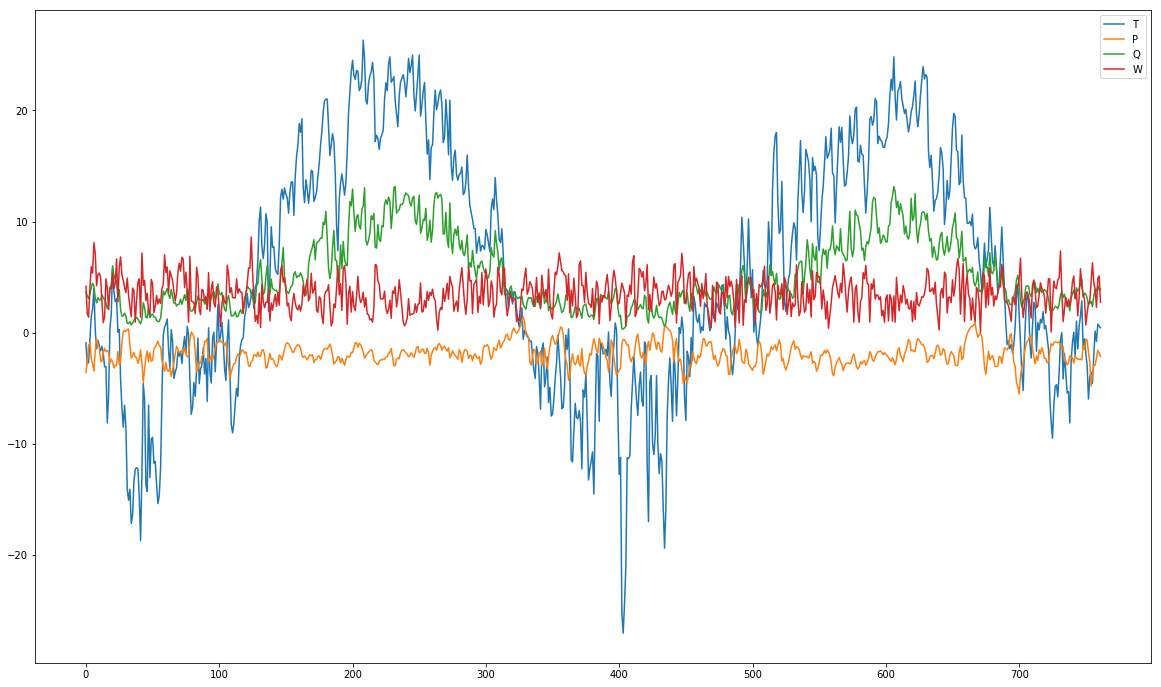

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

T = df['T'].values - 273.15
P = (df['P'].values - 101325) / 1000
Q = df['Q'].values * 1000
W = df['W'].values

# scaler = MinMaxScaler(feature_range=(0, 1))
# T_size = T.size
# T = scaler.fit_transform(T.reshape(-1, 1)).reshape(T_size)
plt.plot(T, label = 'T')
plt.plot(P, label = 'P')
plt.plot(Q, label = 'Q')
plt.plot(W, label = 'W')
plt.legend()
plt.show()

In [11]:
train_T = T[:600].astype('Float32')
train_P = P[:600].astype('Float32')
train_Q = Q[:600].astype('Float32')
train_W = W[:600].astype('Float32')
test_T = T[:].astype('Float32')
test_P = Q[:].astype('Float32')
test_Q = Q[:].astype('Float32')
test_W = W[:].astype('Float32')

C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """Entry point for launching an IPython kernel.
C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  after removing the cwd from sys.path.
C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the fut

In [171]:
def create_dataset(T, P, Q, W, look_back=1):
    dataX, dataY = [], []
    for i in range(len(T)-look_back-1):
        dataX.append([T[i: (i + look_back)], P[i: (i + look_back)], Q[i: (i + look_back)], W[i: (i + look_back)]])
        dataY.append([T[i + look_back], P[i + look_back], Q[i + look_back], W[i + look_back]])
#     return torch.transpose(torch.tensor(np.array(dataX)), 0, 1), torch.tensor(np.array(dataY))
    return torch.tensor(np.array(dataX)), torch.tensor(np.array(dataY))

In [172]:
def create_dataset_test(T, P, Q, W, look_back, start):
    dataX, dataY = [], []
    for i in range(start, T.size):
        dataX.append([T[i - look_back: i], P[i - look_back: i], Q[i - look_back: i], W[i - look_back: i]])
        dataY.append([T[i], P[i], Q[i], W[i]])
    return torch.tensor(np.array(dataX)), torch.tensor(np.array(dataY))

In [173]:
# 2, 3 in 200 steps better than baseline for short term
look_back = 1

In [174]:
model = torch.nn.Sequential(torch.nn.Linear(look_back * 4, 4),).to(torch.device('cpu'))

In [175]:
trainX, trainY = create_dataset(train_T, train_P, train_Q, train_W, look_back)
testX, testY = create_dataset_test(test_T, test_P, test_Q, test_W, look_back, 600)

In [176]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for _ in range(200):
    losses_tmp = []
    for x, y in zip(trainX, trainY):
        x = torch.transpose(x, 0, 1).contiguous().view(-1, x.size(0) * x.size(1))
        y_pred = model.forward(x)
        loss = MSE_torch.forward(y_pred, y)
        losses_tmp.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(np.mean(losses_tmp))
    clear_output(True)
    print(np.mean(losses_tmp))
    plt.plot(losses)
    plt.show()

2.7357092


KeyboardInterrupt: 

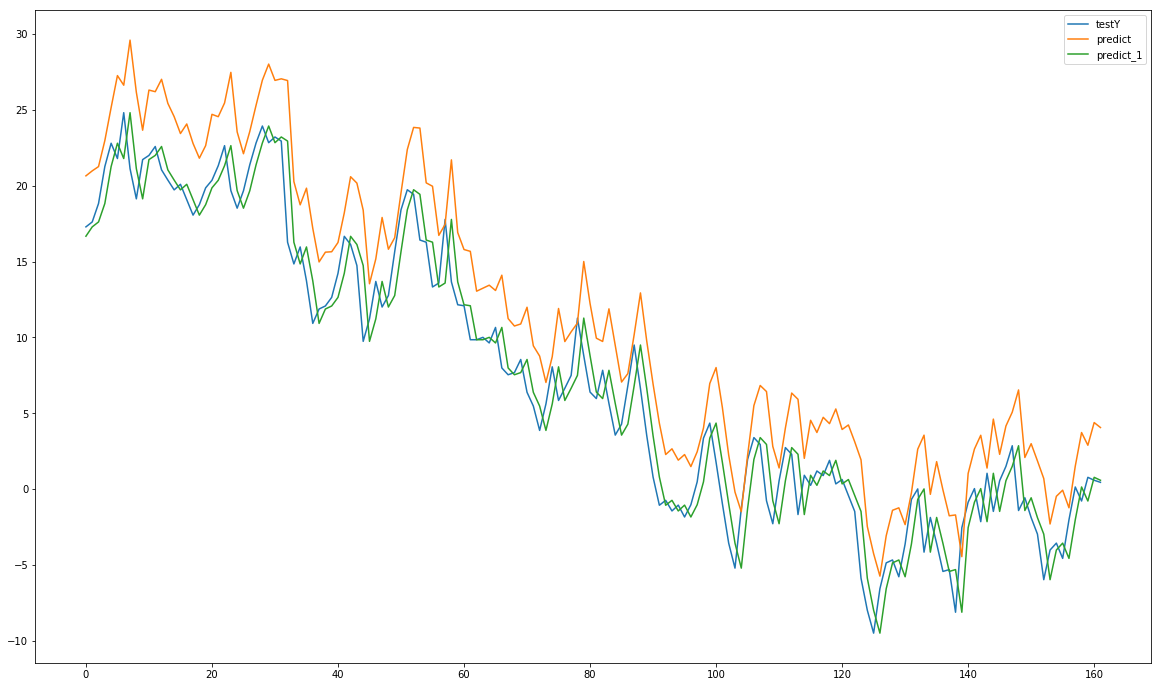

In [183]:
trainX_ten = torch.Tensor(trainX)
predict = []
predict_1 = []
for x in testX:
    predict_1.append(x[0, -1])
    x = torch.transpose(x, 0, 1).contiguous().view(-1, x.size(0) * x.size(1))
    pred = model(x)
    predict.append(pred[0][0])
plt.plot(testY[:, 0].data.tolist(), label='testY')
plt.plot(predict, label='predict')
plt.plot(predict_1, label='predict_1')
plt.legend()
plt.show()

In [186]:
from sklearn.metrics import mean_squared_error as MSE
print('model {}'.format(MSE_sklearn(predict, testY[:, 0].data.tolist())))
print('baseline {}'.format(MSE_sklearn(predict_1, testY[:, 0].data.tolist())))

model 18.933320690725242
baseline 4.334666719040267


### Long-term predict

In [187]:
pred = []
X = testX[0]
X = torch.transpose(X, 0, 1).contiguous().view(-1, X.size(0) * X.size(1))
predict = model(X)
pred.append(predict[0][0].detach().item())
testY = np.array(T[600:])
for _ in range(testY.size - 1):
    X = np.append(X[1:], predict.detach().numpy())
    X = torch.tensor([X])
    X = torch.transpose(X, 0, 1).contiguous().view(-1, X.size(0) * X.size(1))
    predict = model(X)
    pred.append(predict[0][0].detach().item())

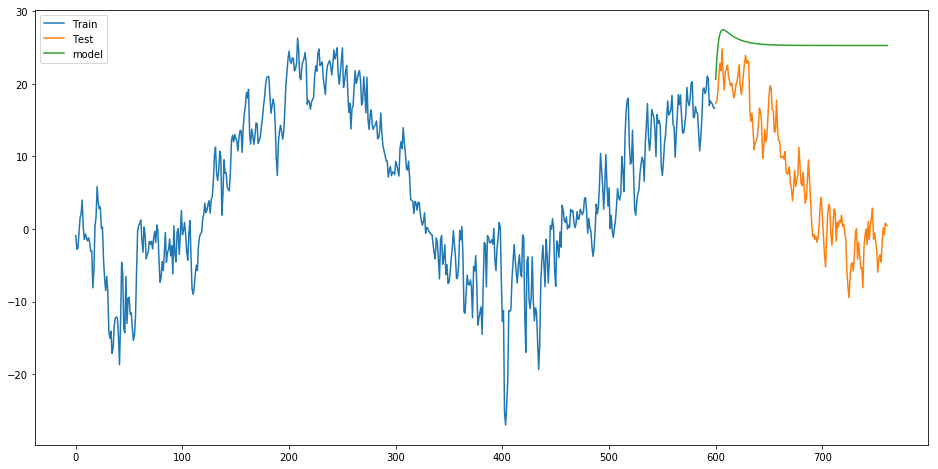

In [189]:
plt.figure(figsize=(16,8))
plt.plot(train_T, label='Train')
plt.plot(range(600, 762), testY, label='Test')
plt.plot(range(600, 762), pred, label='model')
plt.legend(loc='best')
plt.show()

In [190]:
MSE_sklearn(pred, testY)

407.8169166209367